In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _sub_op=None, label=''):
        self.data = data
        self._prev = set(_children)
        self._sub_op = _sub_op
        # label variable to help in the graphviz visualization
        self.label = label
        # internal grad attribute to hold the current gradient of this value wrt the final output (say loss fn)
        self.grad = 0.0 # set to zero, implying it won't cascade a change to the final value yet
        # backward attribute as a fn that propagates the gradient to its child nodes
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # to ensure Value objects add with any python native number data types
        other = Value(other) if not isinstance(other, Value) else other
        # print(type(other))
        children = (self, other)
        out = Value(self.data + other.data, children, '+')
        # To backpropagate from an add fn
        # It just transfers the value from the parent grad to the children grads
        # the gradients have to accumulate, this is esp. important when the same variable (obj) is used
        # to form a parent from an operation requiring two actors. To prevent grads from being overwritten
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    """To define a division operator. Using a specialized form of the power operator"""
    def __truediv__(self, other):
        # would use __pow__ and __mul__ already defined. If you just do plain divide, the graph prolly doesn't know it 
        # cos no labels. Did this to have the entire tanh expression in small units
        return self * other ** -1
    
    def __pow__(self, power):
        assert isinstance(power, (int, float)), "only int and float powers allowed"
        out = Value(math.pow(self.data, power), (self, ), f'**{power}')
        
        def _backward():
            self.grad = out.grad * (power * (self.data ** (power - 1)))
        out._backward = _backward
        return out
    
    """A subtraction operator"""
    def __sub__(self, other):
        # Using the addition of a negation | both operators already implemented
        return self + (-other)
    
    """To allow reverse mult say 2 * Value(4)"""
    def __rmul__(self, other):
        # Take advantage of the already defined __mul__
        return self * other
    
    """To allow reverse addition say 2 + Value(4)"""
    def __radd__(self, other):
        # Take advantage of the already defined __add__
        return self + other
    
    """To produce -ve form of self.data"""
    def __neg__(self):
        # Take advantage of __mul__ defined
        return self * -1
    
    def __mul__(self, other):
        # to ensure Value objects multiply with any python native number data types
        other = Value(other) if not isinstance(other, Value) else other
        children = self, other
        out = Value(self.data * other.data, children, '*')
        # for mult: child1.grad = parent.grad * child2.data
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
        
    def _tanh(self):
        # tanh(x) = 2*sigmoid(2*x) - 1
#         out = ( math.exp(2*self.data) - 1 ) / ( math.exp(2*self.data) + 1 )
        out = ( np.exp(2*self.data) - 1 ) / ( np.exp(2*self.data) + 1 )
        return out
    
    def exp(self):
#         out = Value(math.exp(self.data), (self, ), 'exp')
        out = Value(np.exp(self.data), (self, ), 'exp')
        
        # derivative of exponent of data is same, identical (idempotent?)
        # accumulate the derivatives to avoid overwriting
        def _backward():
            print("data: ", out.data, "grad: ", out.grad)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):        
        out = Value(self._tanh(), _sub_op='tanh', _children=(self, ))
        # self.grad = 1 - tanh(out.data)**2 * out.grad {chain rule}
        def _backward():
            self.grad += ( 1 - (out.data ** 2) ) * out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        # sigmoid(x) = 1 / (1 + e ** -x)
#         temp = math.exp(-1 * self.data)
        temp = np.exp(-1 * self.data)
        val = 1 / (1 + temp)
        out = Value(val, _sub_op='sigmoid', _children=(self,))
        # self.grad = sigmoid(self.data)[out.data] ** 2 * e ** -self.data * out.grad
        def _backward():
            self.grad += (out.data ** 2) * temp * out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(max(self.data, 0), _sub_op='relu', _children=(self,))
        # self.grad = 1 if out.data != 0 else 0 * out.grad
        def _backward():
            self.grad += (1 if out.data != 0 else 0) * out.grad
        out._backward = _backward
        return out    
    
    # method to do backprop in one pass from current object
    def backward(self):
        # we need to call backprop in order from back to front
        # we use a topological sort to first order the graph nodes and then call them in order
        visited = set()
        sorted_nodes = []
        def topo_sort(node):
            if node not in visited:
                visited.add(node)
                # go through child nodes and sort them
                for child in node._prev:
                    topo_sort(child)
                sorted_nodes.append(node)
        topo_sort(self)
        # set grad of self to 1. dself/dself = 1
        self.grad = 1.0
        # call backward in reverse for every child node of self
        for child in reversed(sorted_nodes):
            child._backward()
# To get L to decrease, go in the opposite direction as the gradient. a = a + (-delta * a.grad)
# similarly, to get L to increase, go in the same direction as the grad. a = a + (delta * a.grad)
# Currently using a.grad = -8 as computed below to test
# a = Value(2.0 + (-1 * 0.01 * -1 * 8), label='a')
# a = Value(2.0 + (0.01 * -1 * 8), label='a')
# a = Value(2.0, label='a')
# b = Value(3.0, label='b')
# c = Value(-1, label='c')
# m = a + b; m.label = 'm'
# d = m * c
# d.label = 'd'
# n = Value(8.0, label='n')
# L = n * d
# L.label = 'L'
# L
# d._sub_op
# L**d.data

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR -> Left To Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._sub_op:
            # if this value is a result of an operation, create a sub_op node for it
            dot.node(name = uid + n._sub_op, label = n._sub_op)
            # then connect this node to it
            dot.edge(uid + n._sub_op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the sub_op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._sub_op)
    return dot
 
# help(Digraph)

In [4]:
# manual backprop using `grad_check` below
# dL/dL = 1
# L.grad = 1
# # dL/dn ~= d.data = n.grad
# n.grad = -5
# # dL/dd ~= n.data = d.grad
# d.grad = 8
# # dL/dc = dL/dd * dd/dc = c.grad = d.grad * m.data | m.data = 5 | c.grad = 5 * 8 = 40
# c.grad = d.grad * m.data
# # dL/dm = dL/dd * dd/dm = d.grad * c.data = m.grad | c.data = -1 | m.grad = -1 * 8 = -8
# m.grad = d.grad * c.data

# # dL/da = dL/dd * dd/dm * dm/da = m.grad * 1 (m = a + b) | a.grad = -8
# a.grad = m.grad
# # similarly, dL/db = dL/dd * dd/dm * dm/da = m.grad * 1 | b.grad = -8 | The '+' sub-operator just transfers the gradient
# b.grad = m.grad

# draw_dot(L)

In [5]:
"""To manually compute backprop. See how a small change in any prev node affects final node"""
# def grad_check():
#     # a very small change
#     delta = 0.001
    
#     a = Value(2.0, label='a')
#     b = Value(3.0, label='b')
#     c = Value(-1, label='c')
#     m = a + b; m.label = 'm'
#     d = m * c
#     d.label = 'd'
#     n = Value(8.0, label='n')
#     L = n * d
#     L.label = 'L'
#     L1 = L.data
    
#     # you can add {delta} to any value here to get an L2
#     # Then see what effect that had on L, by comparing it to how it was before the bumping
    
#     a = Value(2.0, label='a')
#     b = Value(3.0, label='b')
#     c = Value(-1 , label='c')
#     m = a + b; m.label = 'm'
#     # m.data += delta
#     d = m * c
#     d.label = 'd'
#     n = Value(8.0, label='n')
#     # d.data = d.data + delta
#     L = n * d
#     L.label = 'L'
#     L2 = L.data
    
#     print(L1, L2)
    
#     gradL = (L2 - L1) / delta
    
#     print(gradL)

# grad_check()
isinstance(4.0, Value)

False

In [6]:
# To model a single perceptron or neuron
# output = activation_fn(sigma(xi * wi) + bias)
# modelling 2 inputs
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')

x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1_plus_x2w2 = x1w1 + x2w2; x1w1_plus_x2w2.label = 'x1w1_plus_x2w2'
bias = Value(6.8814, label='bias')

sigma = x1w1_plus_x2w2 + bias; sigma.label = 'sigma'

# tanh activation function
# out = sigma.tanh(); out.label = 'out'
# implementing tanh using atomic operations. tanh(x) = exp(2*x) - 1 / exp(2*x) + 1
e = (2*sigma).exp(); e.label='e'
out = (e-1) / (e+1); out.label='out'
out.backward()

data:  5.828735025142169 grad:  0.042889350881465754


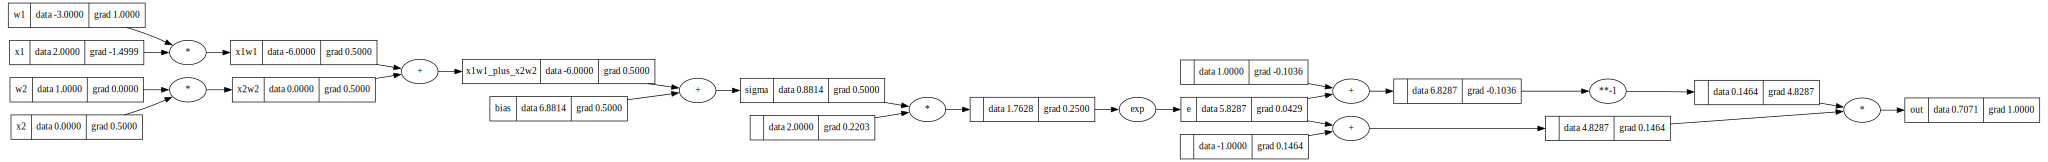

In [7]:
draw_dot(out)
# 0.0429*5.8287

In [8]:
# To do another manual backprop
# d(tanh(out))/d(tanh(out)) = 1
# out.grad = 1.0

# # d(out)/ d(sigma). out = tanh(sigma). sigma.grad =dout/dsigma = 1 - tanh(sigma) ** 2
# sigma.grad = 1 - out.data ** 2

# # dout / dx1w1_plus_x2w2 = x1w1_plus_x2w2.grad = sigma.grad * dsigma/dx1w1_plus_x2w2
# x1w1_plus_x2w2.grad = sigma.grad # plus operation, just propagates the gradient
# bias.grad = sigma.grad

# # similarly:
# x1w1.grad = x1w1_plus_x2w2.grad
# x2w2.grad = x1w1_plus_x2w2.grad

# # x1.grad = dout/dx1 = dout/dsigma * dsigma/dx1w1_plus_x2w2 * dx1w1_plus_x2w2/dx1w1 * dx1w1/dx1 = x1w1.grad * dx1w1/
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

# #similarly
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

In [9]:
out.backward()

data:  5.828735025142169 grad:  0.1286680526443973


In [10]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [11]:
o.data.item()

0.7071066904050358

In [12]:
"""class to represent a single neuron with several inputs"""
class Neuron:
    """initializes Neuron by specifying number of inputs (nin) to it"""
    def __init__(self, nin):
        # initialize weights & bias randomly using uniform distribution
        self._weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self._bias = Value(random.uniform(-1,1))
    
    """calculates and returns output when Neuron object is invoked. Accepts list of inputs to the neuron"""
    def __call__(self, inputs, activation_fn="relu"):
        assert len(self._weights) == len(inputs), "Number of inputs must be same number as specified in neuron initialization"
        # activation_fn(summation(self._weights) + self._bias)
        activation_input = sum([(w * x) for w,x in zip(self._weights, inputs)], self._bias)
        # `activation_input` will stil be a `Value` object as all those operations are specified
        out = activation_input.relu()
        if activation_fn == "tanh":
            out = activation_input.tanh()
        elif activation_fn == "none":
            out = activation_input
        elif activation_fn == "sigmoid":
            out = activation_input.sigmoid()
#         match activation_fn:
#             case "relu":
#                 out = activation_input.relu()
#                 break
#             case _:
#                 out = activation_input.tanh()
#         print("activation input", activation_input, 'tanh', activation_input.tanh(), 'sigmoid', activation_input.sigmoid())
        return out

    """returns a list of the weights and bias of the Neuron object"""
    def get_parameters(self):
        return self._weights + [self._bias]

    
"""class to represent a layer of neurons"""
class Layer:
    """initializes Layer by specifying no. of inputs to each Neuron in the layer, 
        & the no. of neurons (outputs) in the layer"""
    def __init__(self, nin, nout):
        self._neurons = [Neuron(nin) for _ in range(nout)]
    
    """returns the neuron outputs for each of its neurons as a list when invoked given an input list"""
    def __call__(self, inputs, activation_fn='relu'):
        outs = [neuron(inputs, activation_fn=activation_fn) for neuron in self._neurons]
        return outs if len(outs)>1 else outs[0]
    
    """returns a list of all the parameters (weights & biases) for a layer of neurons"""
    def get_parameters(self):
        return [param for neuron in self._neurons for param in neuron.get_parameters()]
    
"""class to represent multilayer perceptron(MLP)"""
class MLP:
    """
    initializes by specifying number of inputs in input layer or to first layer, and 
        nouts - list of number of neurons per layer, size of this list is number of layers
    """
    def __init__(self, nin, nouts):
        layer_input_sizes = [nin] + nouts
        # Layers created such that outputs from previous layers are sequentially fed to current/ newer layers
        """
        sz = [3] + [4, 4, 1]
        [(sz[i], sz[i+1]) for i in range(3)]
        [(3, 4), (4, 4), (4, 1)]
        """
        self._layers = [Layer(layer_input_sizes[i], layer_input_sizes[i+1]) for i in range(len(nouts))]
    
    """
    Returns the output of the entire MLP after call the each layer sequentially with the outputs of the previous layers
    hlaf: hidden layer activation function
    olaf: output layer activation function
    """
    def __call__(self, inputs, hlaf="relu", olaf="sigmoid"):
        layer_output = inputs
        # call for hidden layers
        for i in range(len(self._layers) - 1):
            layer = self._layers[i]
            layer_output = layer(layer_output, hlaf)
        # call for output layer
        layer_output = self._layers[-1](layer_output, olaf)
        return layer_output
    
    """returns a list of all the parameters in the MLP object"""
    def get_parameters(self):
        return [param for layer in self._layers for param in layer.get_parameters()]

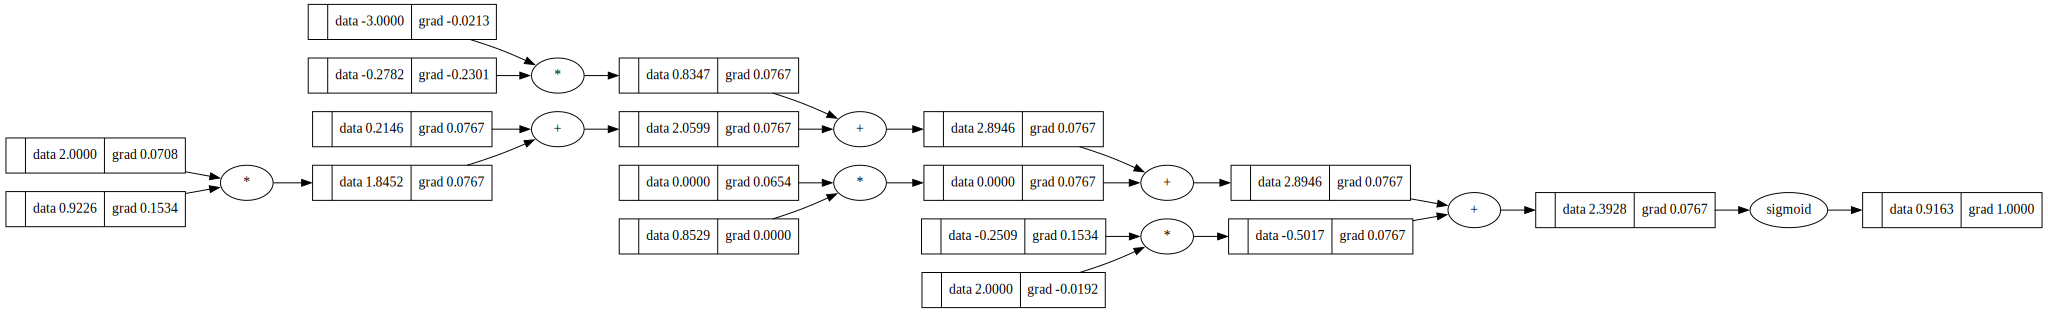

In [13]:
nout = 4
nin = 4
inputs = [2, -3, 0, 2]
# `nout` number of neurons
layer1 = Layer(nin, nout)
outputs = layer1(inputs, 'sigmoid')
outputs[0].backward()
draw_dot(outputs[0])
# for output in outputs:
#     output.backward()
#     draw_dot(output)

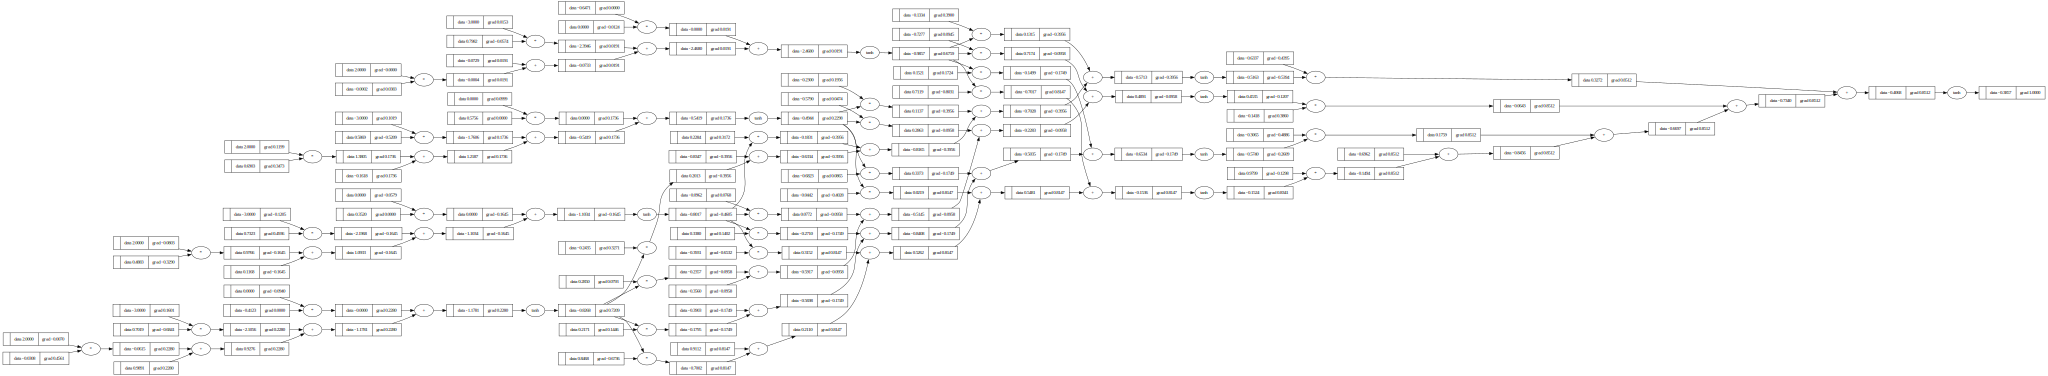

In [14]:
# creating an MLP with input layer of 3 neurons (Just 3 inputs lol),
# 2 hidden layers of 4 neutrons each and one output layer (one neutron)
nouts = [4, 4, 1]
nin = 3
inputs = [2, -3, 0]
mlp = MLP(nin, nouts)
out = mlp(inputs, 'tanh', 'tanh')
out.backward()
draw_dot(out)

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # The labels for each row of `xs`. 2 classes -> 1.0 & -1.0 [binary classification]

# passing each row of xs as input to the MLP
ys_predicted = [mlp(x) for x in xs]
ys_predicted

[Value(data=0.9789690486040195),
 Value(data=0.4333845884855064),
 Value(data=0.6647026312594646),
 Value(data=0.9167612690039465)]

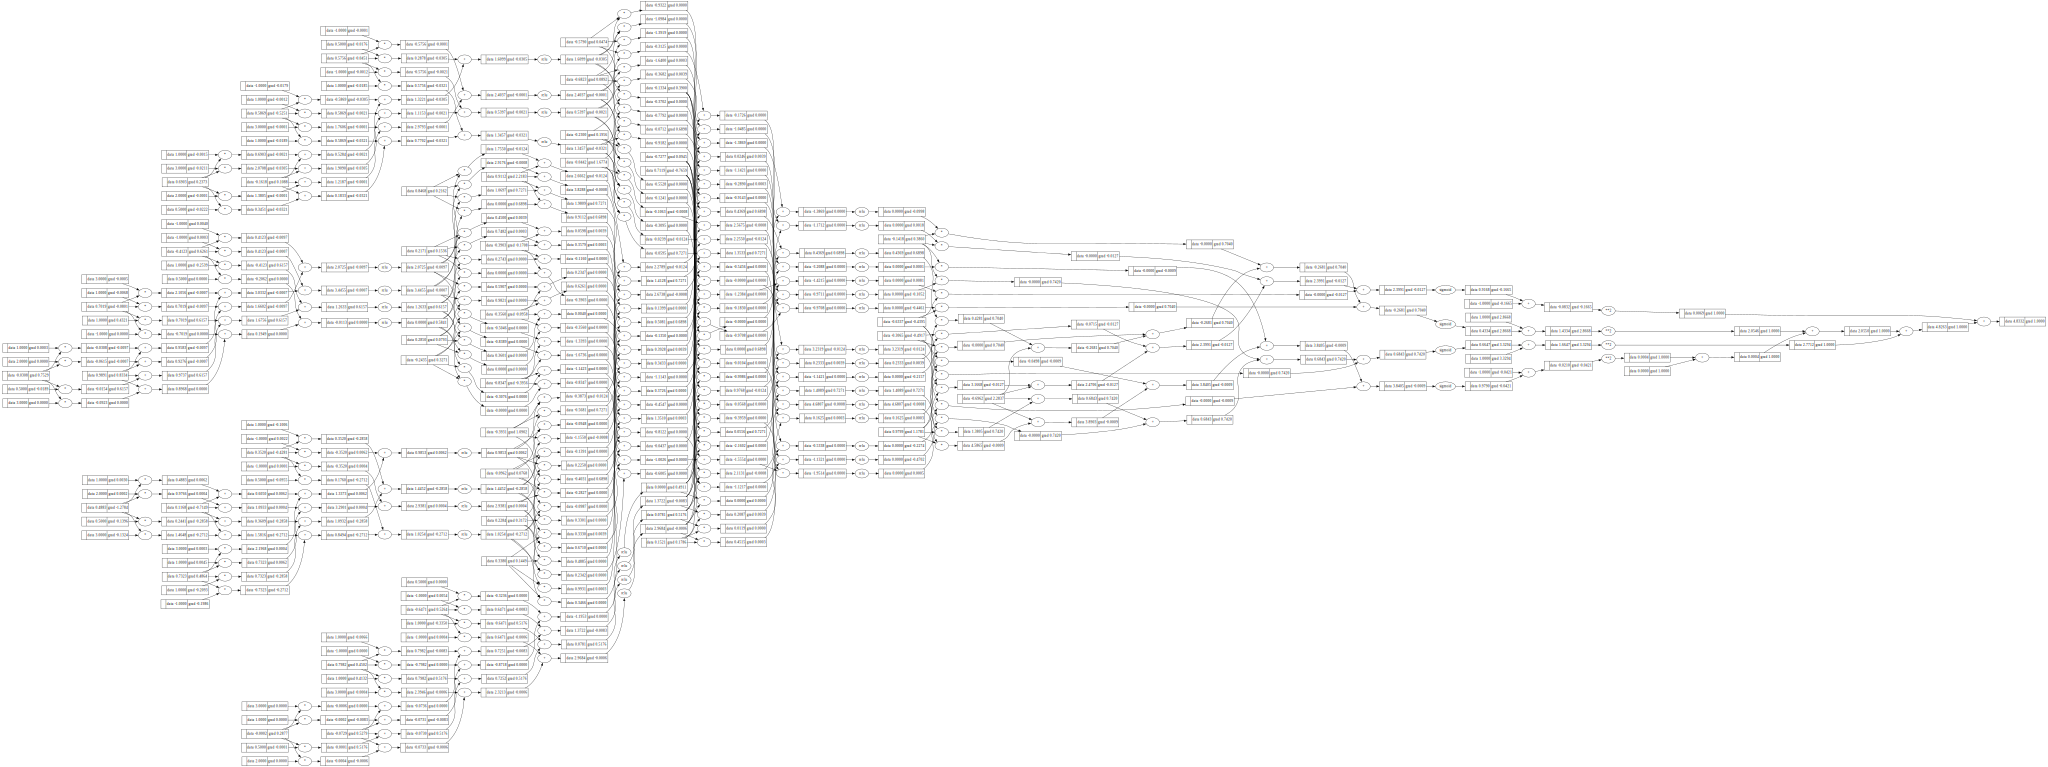

In [16]:
# total loss for all the training data. Sum of losses for each training set [more like a cost function]
loss = sum([( (y_pred - y_actual) ** 2) for y_pred, y_actual in zip(ys_predicted, ys)])
loss.backward()
draw_dot(loss)

In [17]:
loss

Value(data=4.833197216284402)

In [18]:
print(mlp._layers[0]._neurons[1]._bias, mlp._layers[0]._neurons[2]._weights[1].grad)
len(mlp.get_parameters())

Value(data=0.11676903867676014) -0.5251060563905542


41

In [21]:
for i in range(1000):
    # manual gradient descent: Iteratively doing forward pass, backpropagation, and updating all parameters
    # forward pass
    ys_predicted = [mlp(x) for x in xs]

    # calculate loss
    loss = sum([( (y_pred - y_actual) ** 2) for y_pred, y_actual in zip(ys_predicted, ys)])
    # backward pass
    loss.backward()
    print(loss, ys_predicted)
    # learning rate
    step_size = 0.1

    # for -VE grad(slope), the minimum loss is to the right (Loss vs Param curve) -> param has to be increased
    # for +VE grad(slope), minimum loss is to the left -> param has to be decreased
    # General expression for this: new_param.data = old_param.data + (-step_size * old_param.grad)
    for param in mlp.get_parameters():
        param.data += (-step_size) * param.grad
        # As data changes, param.grad has to be reset to zero, so the next backward pass doesn't just 
        # accumulate the new grad values atop the old
        param.grad = 0.0

Value(data=2.018871593920695) [Value(data=0.9998369073569152), Value(data=0.0046660965768275066), Value(data=0.0046660965768275066), Value(data=0.9872079673371755)]
Value(data=2.0188368621082184) [Value(data=0.9998375463235912), Value(data=0.004657586229692947), Value(data=0.004657586229692947), Value(data=0.9872287596813738)]
Value(data=2.018802257816191) [Value(data=0.9998381807204526), Value(data=0.004649106600705419), Value(data=0.004649106600705419), Value(data=0.9872494375214147)]
Value(data=2.0187677803390227) [Value(data=0.999838810597206), Value(data=0.004640657525742868), Value(data=0.004640657525742868), Value(data=0.9872700019840993)]
Value(data=2.018733428976424) [Value(data=0.9998394360028229), Value(data=0.004632238841828761), Value(data=0.004632238841828761), Value(data=0.9872904541805788)]
Value(data=2.01869920303335) [Value(data=0.999840056985555), Value(data=0.004623850387122427), Value(data=0.004623850387122427), Value(data=0.9873107952066299)]
Value(data=2.01866510

Value(data=2.0163444455519484) [Value(data=0.9998734833793269), Value(data=0.004044717416119804), Value(data=0.004044717416119804), Value(data=0.9884743588871702)]
Value(data=2.0163183700081055) [Value(data=0.9998738894297133), Value(data=0.004038310958801394), Value(data=0.004038310958801394), Value(data=0.9884893806324728)]
Value(data=2.016292377687544) [Value(data=0.9998742963483962), Value(data=0.004031924624403581), Value(data=0.004031924624403581), Value(data=0.988504324457962)]
Value(data=2.0162664665198338) [Value(data=0.9998746977356845), Value(data=0.00402555831927556), Value(data=0.00402555831927556), Value(data=0.9885192638515427)]
Value(data=2.0162406399506922) [Value(data=0.9998750999905333), Value(data=0.00401921194902262), Value(data=0.00401921194902262), Value(data=0.988534031867863)]
Value(data=2.0162148925555576) [Value(data=0.9998754967952924), Value(data=0.004012885422849804), Value(data=0.004012885422849804), Value(data=0.9885488487794238)]
Value(data=2.0161892282

Value(data=2.014499752007575) [Value(data=0.9998905147251177), Value(data=0.0035891009079009164), Value(data=0.0035891009079009164), Value(data=0.9891568870571222)]
Value(data=2.0144792033625625) [Value(data=0.9998908389552645), Value(data=0.003584053539094261), Value(data=0.003584053539094261), Value(data=0.9891701149355296)]
Value(data=2.0144587128407325) [Value(data=0.9998911614355032), Value(data=0.003579020241432571), Value(data=0.003579020241432571), Value(data=0.9891832880508123)]
Value(data=2.0144382801945158) [Value(data=0.999891482180203), Value(data=0.0035740009567263482), Value(data=0.0035740009567263482), Value(data=0.9891964068099952)]
Value(data=2.014417905177768) [Value(data=0.9998918012035727), Value(data=0.0035689956271015254), Value(data=0.0035689956271015254), Value(data=0.9892094716158175)]
Value(data=2.0143975898549944) [Value(data=0.9998921185196625), Value(data=0.003564004194997405), Value(data=0.003564004194997405), Value(data=0.9892223757354879)]
Value(data=2.

Value(data=2.0130246715412436) [Value(data=0.9999080157125936), Value(data=0.003225510132629018), Value(data=0.003225510132629018), Value(data=0.9899096720376952)]
Value(data=2.0130080804749504) [Value(data=0.9999082534730087), Value(data=0.0032214294217242996), Value(data=0.0032214294217242996), Value(data=0.9899203593521468)]
Value(data=2.0129915329550108) [Value(data=0.9999084901191014), Value(data=0.0032173589551947545), Value(data=0.0032173589551947545), Value(data=0.9899309403179573)]
Value(data=2.012975026302395) [Value(data=0.9999087274819244), Value(data=0.0032132986956982103), Value(data=0.0032132986956982103), Value(data=0.9899415402812491)]
Value(data=2.012958561956229) [Value(data=0.9999089619241192), Value(data=0.0032092486044856495), Value(data=0.0032092486044856495), Value(data=0.9899520799592909)]
Value(data=2.0129421395100264) [Value(data=0.9999091970796408), Value(data=0.003205208644007338), Value(data=0.003205208644007338), Value(data=0.9899625718471533)]
Value(data

Value(data=2.0119318938988906) [Value(data=0.999919682536699), Value(data=0.0029558483170372117), Value(data=0.0029558483170372117), Value(data=0.9904595544495934)]
Value(data=2.011917962405532) [Value(data=0.999919872281422), Value(data=0.0029524189881192445), Value(data=0.0029524189881192445), Value(data=0.9904686581825372)]
Value(data=2.011904063435829) [Value(data=0.9999200597825934), Value(data=0.002948997558623526), Value(data=0.002948997558623526), Value(data=0.9904777293834294)]
Value(data=2.0118901972966747) [Value(data=0.9999202479232013), Value(data=0.002945584001531337), Value(data=0.002945584001531337), Value(data=0.9904867460910886)]
Value(data=2.011876362501846) [Value(data=0.9999204338441893), Value(data=0.002942178290188876), Value(data=0.002942178290188876), Value(data=0.9904957807193341)]
Value(data=2.0118625609628267) [Value(data=0.999920618982269), Value(data=0.002938780397268217), Value(data=0.002938780397268217), Value(data=0.9905047268622363)]
Value(data=2.01184

Value(data=2.0111516594843737) [Value(data=0.9999277979959116), Value(data=0.0027632426430280114), Value(data=0.0027632426430280114), Value(data=0.9908669457833847)]
Value(data=2.0111394850461584) [Value(data=0.9999279548091677), Value(data=0.0027602440789948036), Value(data=0.0027602440789948036), Value(data=0.9908749989085918)]
Value(data=2.0111273379305015) [Value(data=0.9999281110084912), Value(data=0.0027572519780494917), Value(data=0.0027572519780494917), Value(data=0.9908829844063265)]
Value(data=2.0111152167398743) [Value(data=0.9999282677864288), Value(data=0.0027542663199005063), Value(data=0.0027542663199005063), Value(data=0.9908909743199453)]
Value(data=2.011103121936998) [Value(data=0.9999284227693562), Value(data=0.002751287083631169), Value(data=0.002751287083631169), Value(data=0.9908989386366281)]
Value(data=2.0110931998066683) [Value(data=0.9999285783276507), Value(data=0.0027483142487109364), Value(data=0.0027493843005490528), Value(data=0.990906856327361)]
Value(da

Value(data=2.0104567484125475) [Value(data=0.9999341608838844), Value(data=0.002591514065659142), Value(data=0.002591514065659142), Value(data=0.9912104650397923)]
Value(data=2.01044603992502) [Value(data=0.9999342949937635), Value(data=0.002588875597332788), Value(data=0.002588875597332788), Value(data=0.9912177073139161)]
Value(data=2.010435353289076) [Value(data=0.9999344296238538), Value(data=0.002586242465887977), Value(data=0.002586242465887977), Value(data=0.9912249315749494)]
Value(data=2.0104246881010606) [Value(data=0.9999345627510149), Value(data=0.0025836146552425817), Value(data=0.0025836146552425817), Value(data=0.9912321571248361)]
Value(data=2.010414045444362) [Value(data=0.9999346963954842), Value(data=0.0025809921492073967), Value(data=0.0025809921492073967), Value(data=0.9912393184042144)]
Value(data=2.0104034236191306) [Value(data=0.9999348285508057), Value(data=0.0025783749322418727), Value(data=0.0025783749322418727), Value(data=0.9912465087957196)]
Value(data=2.0

Value(data=2.0097323788707233) [Value(data=0.9999388765753859), Value(data=0.0024120551771504377), Value(data=0.0024120551771504377), Value(data=0.9914842260661021)]
Value(data=2.0097230958634835) [Value(data=0.9999389970719469), Value(data=0.0024097692850592175), Value(data=0.0024097692850592175), Value(data=0.9914911207626865)]
Value(data=2.0097138305438507) [Value(data=0.999939117134233), Value(data=0.0024074876943627785), Value(data=0.0024074876943627785), Value(data=0.9914979963726723)]
Value(data=2.0097045828610733) [Value(data=0.9999392367646315), Value(data=0.0024052103930332484), Value(data=0.0024052103930332484), Value(data=0.9915048529912535)]
Value(data=2.009695352764599) [Value(data=0.9999393559655114), Value(data=0.002402937369086957), Value(data=0.002402937369086957), Value(data=0.9915116907129496)]
Value(data=2.0096861402040687) [Value(data=0.9999394747392248), Value(data=0.0024006686105842363), Value(data=0.0024006686105842363), Value(data=0.9915185096316137)]
Value(da

Value(data=2.0090756310454694) [Value(data=0.9999451762111892), Value(data=0.0022498046887608394), Value(data=0.0022498046887608394), Value(data=0.9918583759296443)]
Value(data=2.009067556287728) [Value(data=0.999945276033678), Value(data=0.0022478150020392804), Value(data=0.0022478150020392804), Value(data=0.9918644028927722)]
Value(data=2.009059495771765) [Value(data=0.9999453747937187), Value(data=0.0022458288109230497), Value(data=0.0022458288109230497), Value(data=0.9918704212862121)]
Value(data=2.0090514499855168) [Value(data=0.9999454739587191), Value(data=0.002243846106231196), Value(data=0.002243846106231196), Value(data=0.9918763987784984)]
Value(data=2.009043417917128) [Value(data=0.9999455720699828), Value(data=0.002241866879047051), Value(data=0.002241866879047051), Value(data=0.9918823954066937)]
Value(data=2.0090354005977464) [Value(data=0.9999456698591566), Value(data=0.0022398911200541952), Value(data=0.0022398911200541952), Value(data=0.9918883453410788)]
Value(data=2

Value(data=2.0084872292181566) [Value(data=0.9999509675782023), Value(data=0.002104466963538067), Value(data=0.002104466963538067), Value(data=0.9922217355776393)]
Value(data=2.008480165809891) [Value(data=0.9999510490979789), Value(data=0.0021027251211093965), Value(data=0.0021027251211093965), Value(data=0.9922269681981408)]
Value(data=2.008473113658423) [Value(data=0.9999511309739753), Value(data=0.0021009861443604025), Value(data=0.0021009861443604025), Value(data=0.9922322199282977)]
Value(data=2.0084660734383255) [Value(data=0.9999512120032374), Value(data=0.002099250026073093), Value(data=0.002099250026073093), Value(data=0.9922374454964278)]
Value(data=2.0084590449402464) [Value(data=0.9999512933868814), Value(data=0.002097516759344529), Value(data=0.002097516759344529), Value(data=0.9922426565485715)]
Value(data=2.00845202779348) [Value(data=0.9999513739301034), Value(data=0.002095786337219347), Value(data=0.002095786337219347), Value(data=0.9922478751709096)]
Value(data=2.008

Value(data=2.007958186540377) [Value(data=0.9999556005790222), Value(data=0.0019736603107145386), Value(data=0.0019736603107145386), Value(data=0.9925332298705654)]
Value(data=2.007951973973861) [Value(data=0.9999556697625958), Value(data=0.001972127652921425), Value(data=0.001972127652921425), Value(data=0.9925379076629612)]
Value(data=2.0079457711194175) [Value(data=0.9999557382478587), Value(data=0.0019705973615147597), Value(data=0.0019705973615147597), Value(data=0.9925425737460161)]
Value(data=2.0079395781238425) [Value(data=0.9999558070446911), Value(data=0.001969069431064087), Value(data=0.001969069431064087), Value(data=0.9925472167802852)]
Value(data=2.007933394422706) [Value(data=0.9999558751480366), Value(data=0.0019675438562212245), Value(data=0.0019675438562212245), Value(data=0.992551873177366)]
Value(data=2.0079281690621706) [Value(data=0.9999559430615529), Value(data=0.001966020631443769), Value(data=0.001966493855001812), Value(data=0.9925564918848427)]
Value(data=2.0

Value(data=2.0075916182662215) [Value(data=0.9999584375649134), Value(data=0.0018829365105498409), Value(data=0.0018829365105498409), Value(data=0.9927350432361913)]
Value(data=2.0075859633086766) [Value(data=0.999958499432633), Value(data=0.001881541217422303), Value(data=0.001881541217422303), Value(data=0.9927393993372114)]
Value(data=2.0075803169173607) [Value(data=0.9999585606856308), Value(data=0.001880147980153916), Value(data=0.001880147980153916), Value(data=0.9927437360389276)]
Value(data=2.0075746789689095) [Value(data=0.9999586222224917), Value(data=0.0018787567942904408), Value(data=0.0018787567942904408), Value(data=0.9927480605736834)]
Value(data=2.007569049149426) [Value(data=0.9999586831486841), Value(data=0.001877367655351655), Value(data=0.001877367655351655), Value(data=0.9927523933391356)]
Value(data=2.0075634281211547) [Value(data=0.9999587439123984), Value(data=0.0018759805587609233), Value(data=0.0018759805587609233), Value(data=0.992756687364694)]
Value(data=2.

Value(data=2.0073146135349393) [Value(data=0.9999603498198156), Value(data=0.0018143218780300333), Value(data=0.0018143218780300333), Value(data=0.99287673368964)]
Value(data=2.0073093628858523) [Value(data=0.9999604070578278), Value(data=0.0018130262760264043), Value(data=0.0018130262760264043), Value(data=0.9928808648284564)]
Value(data=2.0073041193703025) [Value(data=0.9999604637341234), Value(data=0.0018117325136771528), Value(data=0.0018117325136771528), Value(data=0.9928850155955574)]
Value(data=2.007298883603793) [Value(data=0.9999605202629211), Value(data=0.0018104405869511044), Value(data=0.0018104405869511044), Value(data=0.9928891416058768)]
Value(data=2.007293655272903) [Value(data=0.9999605770557611), Value(data=0.0018091504920543743), Value(data=0.0018091504920543743), Value(data=0.9928932637933382)]
Value(data=2.00728843429554) [Value(data=0.9999606332914301), Value(data=0.0018078622250973268), Value(data=0.0018078622250973268), Value(data=0.9928973868356163)]
Value(data

Value(data=2.0069179984408803) [Value(data=0.9999635874259365), Value(data=0.00171620012374548), Value(data=0.00171620012374548), Value(data=0.9931220690397671)]
Value(data=2.00691330023279) [Value(data=0.999963636481215), Value(data=0.0017150405016496104), Value(data=0.0017150405016496104), Value(data=0.9931258327019112)]
Value(data=2.006908608664618) [Value(data=0.9999636854165572), Value(data=0.00171388243783853), Value(data=0.00171388243783853), Value(data=0.9931295699920892)]
Value(data=2.0069039232808144) [Value(data=0.999963734586806), Value(data=0.0017127259292834189), Value(data=0.0017127259292834189), Value(data=0.993133313150982)]
Value(data=2.0068992442536917) [Value(data=0.9999637832837054), Value(data=0.0017115709728135948), Value(data=0.0017115709728135948), Value(data=0.9931370487108075)]
Value(data=2.006894571716321) [Value(data=0.9999638322144431), Value(data=0.0017104175653294873), Value(data=0.0017104175653294873), Value(data=0.9931407660487328)]
Value(data=2.006889